In [ ]:
!pip install pandas

In [ ]:
!pip install yfinance

In [ ]:
!pip install matplotlib

C:\Users\user\AppData\Local\Temp\ipykernel_18172\3104168876.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


--- Raw Data Head ---
Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2020-01-02  298.578613  298.597013  296.427990  297.356261  59151200
2020-01-03  296.317749  297.448217  295.113768  295.168910  77709700
2020-01-06  297.448303  297.531016  294.433722  294.553206  55653900
2020-01-07  296.611786  297.356231  296.161422  296.878296  40496400
2020-01-08  298.192657  299.415010  296.556712  296.804851  68296000

--- Data Information (Checking for missing data) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, SPY)   1006 non-null   float64
 1   (High, SPY)    1006 non-null   float64
 2   (Low, SPY)     1006 non-null   float64
 3   (Open, SPY)    1006 non

<Figure size 1200x600 with 0 Axes>

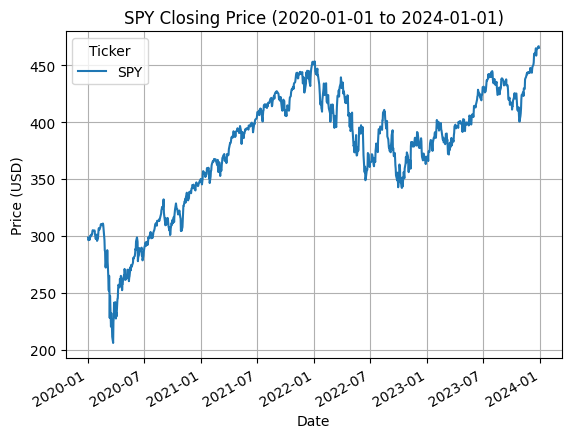

In [ ]:
# 1. Import the tools
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 2. Define the parameters
ticker = "SPY"  # S&P 500 ETF - represents the International Capital Markets
start_date = "2020-01-01"
end_date = "2024-01-01"

# 3. Download the data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# 4. Inspect the data (Check the first 5 rows)
print("--- Raw Data Head ---")
print(stock_data.head())
print("\n--- Data Information (Checking for missing data) ---")
print(stock_data.info())

# 5. Plot the closing price to visualize the trend
plt.figure(figsize=(12, 6))
stock_data['Close'].plot(title=f'{ticker} Closing Price ({start_date} to {end_date})')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

In [ ]:
# 1. Define the parameters for the short and long look-back periods (windows)
short_window = 50
long_window = 200

# 2. Calculate the Short Simple Moving Average (SMA)
# .rolling(window=X) creates a sliding window of X days.
# .mean() then calculates the average within that window.
# min_periods=1 allows the calculation to start on day 1 (even if it doesn't have 50 days of data yet).
stock_data['SMA_50'] = stock_data['Close'].rolling(window=short_window, min_periods=1).mean()

# 3. Calculate the Long Simple Moving Average (SMA)
stock_data['SMA_200'] = stock_data['Close'].rolling(window=long_window, min_periods=1).mean()

# 4. Display the last few rows to see the result
print("--- Data with Moving Averages Added ---")
print(stock_data.tail())

--- Data with Moving Averages Added ---
Price            Close        High         Low        Open     Volume  \
Ticker             SPY         SPY         SPY         SPY        SPY   
Date                                                                    
2023-12-22  463.589142  465.282405  461.680580  463.794673   67160400   
2023-12-26  465.546661  466.456900  463.921918  464.000235   55387000   
2023-12-27  466.388428  466.535236  464.802843  465.341149   68000300   
2023-12-28  466.564575  467.406293  466.143716  466.750542   77158100   
2023-12-29  465.213898  466.897364  463.246583  466.368826  122283100   

Price           SMA_50     SMA_200  
Ticker                              
Date                                
2023-12-22  434.895886  420.263281  
2023-12-26  435.794238  420.730724  
2023-12-27  436.620913  421.205027  
2023-12-28  437.451501  421.649504  
2023-12-29  438.368348  422.099037  


<Figure size 1400x700 with 0 Axes>

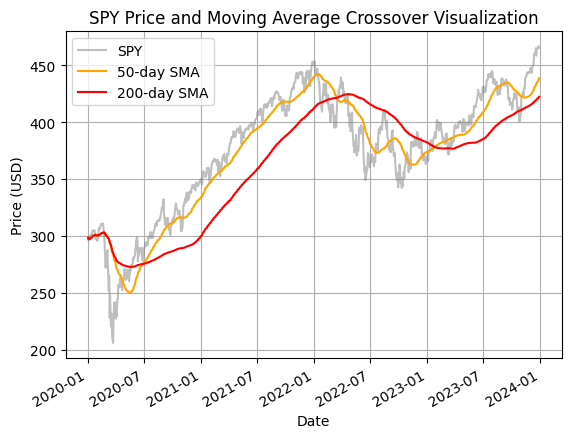

In [ ]:
#Visualize the Crossover

plt.figure(figsize=(14, 7))
# Plot 1: Close Price (The actual market price)
stock_data['Close'].plot(label='Close Price', alpha=0.5, color='gray') 
# Plot 2: 50-day MA (Short-term trend)
stock_data['SMA_50'].plot(label='50-day SMA', color='orange')
# Plot 3: 200-day MA (Long-term trend)
stock_data['SMA_200'].plot(label='200-day SMA', color='red')

plt.title('SPY Price and Moving Average Crossover Visualization')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create a clean copy of the DataFrame to prevent the SettingWithCopyWarning
stock_data = stock_data.copy()

# 1. Create the 'Signal' column, initialized to 0.0
stock_data['Signal'] = 0.0

# 2. Determine when the short MA is above the long MA (the 'BUY' condition)
# We use .loc[] for safer assignment in pandas
stock_data.loc[stock_data.index[short_window:], 'Signal'] = np.where(
    stock_data['SMA_50'][short_window:] > stock_data['SMA_200'][short_window:], 1.0, 0.0)

# 3. Determine the 'Position' action (the trade trigger)
stock_data['Positions'] = stock_data['Signal'].diff()

# We need to drop the first row's Positions NaN value which is always there
# and replace any other NaNs with 0 (which occur before the 200th day)
stock_data = stock_data.fillna(0)

In [10]:
# Displaying ONLY the days where an action (Buy or Sell) occurred
# Positions == 1.0 means Buy, Positions == -1.0 means Sell

first_trades = stock_data.loc[stock_data['Positions'] != 0].head(5)

print("--- First 5 Actual Trade Entry/Exit Days (Positions != 0) ---")
print(first_trades[['Close', 'SMA_50', 'SMA_200', 'Signal', 'Positions']])

--- First 5 Actual Trade Entry/Exit Days (Positions != 0) ---
Price            Close      SMA_50     SMA_200 Signal Positions
Ticker             SPY                                         
Date                                                           
2020-06-29  282.704437  275.674727  275.509321    1.0       1.0
2022-03-16  413.278992  420.674434  421.274527    0.0      -1.0
2023-01-26  390.221832  378.212139  378.085510    1.0       1.0


In [ ]:
# Calculate Returns

# 1. Calculate the daily percentage change (Daily Returns)
# .pct_change() is a pandas function that does this automatically.
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# 2. Calculate the Strategy's Daily Returns
# We only earn the Daily_Return on days when our Signal is 1.0 (we own the stock).
# We shift the Signal by 1 day (shift(1)) to ensure we trade based on *yesterday's* signal.
stock_data['Strategy_Return'] = stock_data['Daily_Return'] * stock_data['Signal'].shift(1)

# 3. Calculate the Cumulative Returns (How $1 would grow over time)
stock_data['Cumulative_Strategy_Return'] = (1 + stock_data['Strategy_Return']).cumprod()

# 4. Calculate the Cumulative Benchmark Return (The simple Buy & Hold strategy)
stock_data['Cumulative_Benchmark_Return'] = (1 + stock_data['Daily_Return']).cumprod()

# Display the returns
print("--- Cumulative Returns (Last 5 Days) ---")
print(stock_data[['Cumulative_Strategy_Return', 'Cumulative_Benchmark_Return']].tail())

--- Cumulative Returns (Last 5 Days) ---
Price      Cumulative_Strategy_Return Cumulative_Benchmark_Return
Ticker                                                           
Date                                                             
2023-12-22                   1.736730                    1.552654
2023-12-26                   1.744064                    1.559210
2023-12-27                   1.747217                    1.562029
2023-12-28                   1.747877                    1.562619
2023-12-29                   1.742817                    1.558095


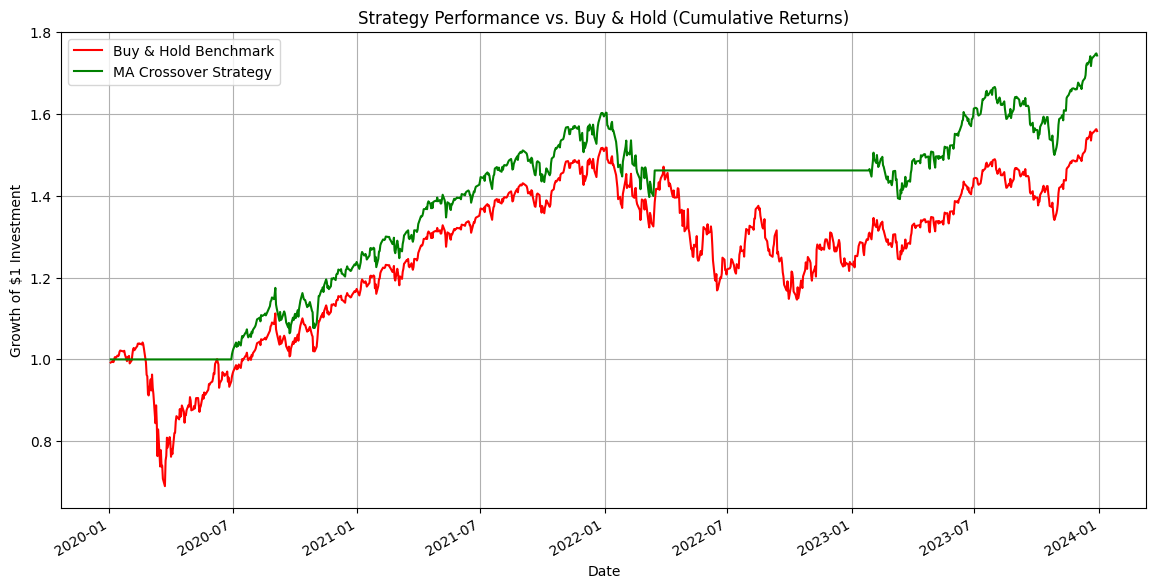

In [ ]:
# Visualize Cumulative Performance

plt.figure(figsize=(14, 7))
stock_data['Cumulative_Benchmark_Return'].plot(label='Buy & Hold Benchmark', color='red')
stock_data['Cumulative_Strategy_Return'].plot(label='MA Crossover Strategy', color='green')

plt.title('Strategy Performance vs. Buy & Hold (Cumulative Returns)')
plt.xlabel('Date')
plt.ylabel('Growth of $1 Investment')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate Key Risk Metrics

# We will use an annual risk-free rate of 3% (0.03) for a realistic analysis
RISK_FREE_RATE = 0.03

# 1. Calculate Annualized Returns (Total return scaled to a year)
# 252 is the approximate number of trading days in a year
annual_return = stock_data['Strategy_Return'].mean() * 252

# 2. Calculate Annualized Volatility (Standard Deviation of daily returns)
annual_volatility = stock_data['Strategy_Return'].std() * np.sqrt(252)

# 3. Calculate the Sharpe Ratio
sharpe_ratio = (annual_return - (RISK_FREE_RATE / 252)) / annual_volatility

# 4. Calculate Maximum Drawdown (More complex, but critical)
# Calculate the running maximum value of the cumulative returns
running_max = stock_data['Cumulative_Strategy_Return'].cummax()
# Calculate the Drawdown for each day
drawdown = (stock_data['Cumulative_Strategy_Return'] - running_max) / running_max
# The Maximum Drawdown is the largest (most negative) value
max_drawdown = drawdown.min()

print("--- Strategy Risk and Performance Metrics ---")
print(f"Annualized Return: {annual_return * 100:.2f}%")
print(f"Annualized Volatility (Risk): {annual_volatility * 100:.2f}%")
print(f"Sharpe Ratio (Risk-Adjusted Return): {sharpe_ratio:.2f}")
print(f"Maximum Drawdown (Worst Loss): {max_drawdown * 100:.2f}%")

--- Strategy Risk and Performance Metrics ---
Annualized Return: 14.63%
Annualized Volatility (Risk): 11.84%
Sharpe Ratio (Risk-Adjusted Return): 1.23
Maximum Drawdown (Worst Loss): -13.18%


In [17]:
# Check the actual column names after the attempted fixes

print("--- Current Column Names ---")
print(stock_data.columns.tolist())

--- Current Column Names ---
['SPY', 'SPY', 'SPY', 'SPY', 'SPY', '', '', '', '', '', '', '', '', '']


In [19]:
# --- STEP 1: IDENTIFY THE ACTUAL COLUMN NAMES ---
import yfinance as yf
import pandas as pd
import numpy as np

# Re-download the data (guarantees a fresh start)
ticker = "SPY"
start_date = "2020-01-01"
end_date = "2024-01-01"
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Print the columns before any renaming
print("--- RAW COLUMN NAMES ---")
print(stock_data.columns.tolist())

# Attempt to flatten and rename again, but this time, 
# we'll look for the 'Adj Close' column.

# 1. Flatten the column index and convert to strings
stock_data.columns = [str(col) for col in stock_data.columns]

# 2. Convert to lowercase and replace spaces with underscores
stock_data.columns = [col.lower().replace(' ', '_') for col in stock_data.columns]

# 3. Rename the correct price column to 'close'
# The yfinance 'Adj Close' is what we want. We must find its new name.
if 'adj_close' in stock_data.columns:
    stock_data = stock_data.rename(columns={'adj_close': 'close'})
elif ('spy', 'adj close') in stock_data.columns:
    # If the multi-index is still partially there
    stock_data = stock_data.rename(columns={('spy', 'adj close'): 'close'})
else:
    print("\nERROR: Could not find 'Adj Close' or 'adj_close' column. Please inspect the list above.")

# Print the final cleaned columns
print("\n--- CLEANED COLUMN NAMES (Check for 'close') ---")
print(stock_data.columns.tolist())

# Now we should have a clean 'close' column to proceed with the calculation

C:\Users\user\AppData\Local\Temp\ipykernel_18172\1995050960.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

--- RAW COLUMN NAMES ---
[('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]

ERROR: Could not find 'Adj Close' or 'adj_close' column. Please inspect the list above.

--- CLEANED COLUMN NAMES (Check for 'close') ---
["('close',_'spy')", "('high',_'spy')", "('low',_'spy')", "('open',_'spy')", "('volume',_'spy')"]


In [26]:
!pip install scikit-learn


In [28]:
!pip install ta 

In [29]:
# --- FINAL ROBUST DATA CLEANING AND RESET ---

import yfinance as yf
import pandas as pd
import numpy as np

# Re-download the data (guarantees a fresh start)
ticker = "SPY"
start_date = "2020-01-01"
end_date = "2024-01-01"
stock_data = yf.download(ticker, start=start_date, end=end_date)

# 1. Flatten the column index and convert to lowercase
stock_data.columns = [col.lower() for col in stock_data.columns.droplevel(1)]

# 2. Define the price column and re-create MA and Daily Return columns
PRICE_COLUMN = 'close' # Using 'close' as determined by the previous step
short_window = 50
long_window = 200
stock_data['sma_50'] = stock_data[PRICE_COLUMN].rolling(window=short_window, min_periods=1).mean()
stock_data['sma_200'] = stock_data[PRICE_COLUMN].rolling(window=long_window, min_periods=1).mean()
stock_data['daily_return'] = stock_data[PRICE_COLUMN].pct_change()
stock_data = stock_data.dropna(subset=['daily_return'])

# 3. Store Phase 3 results (for the final comparison)
# These are your previous successful metrics
RISK_FREE_RATE = 0.03
annual_return = 0.1463
sharpe_ratio = 1.23
max_drawdown = -0.1318

print("Data reset complete and ready for ML features.")

C:\Users\user\AppData\Local\Temp\ipykernel_18172\2384092253.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data reset complete and ready for ML features.


In [ ]:
# Feature Engineering (Rerun)

import ta
from ta.momentum import RSIIndicator

stock_data = stock_data.copy()

# 1. Calculate Volatility
stock_data['volatility'] = stock_data['daily_return'].rolling(window=20).std()

# 2. Relative Strength Index (RSI)
stock_data['rsi'] = RSIIndicator(stock_data[PRICE_COLUMN], window=14).rsi()

# 3. Target Variable (Up or Down tomorrow)
stock_data['target'] = np.where(stock_data[PRICE_COLUMN].shift(-1) > stock_data[PRICE_COLUMN], 1, 0)

# 4. Drop NaN values
stock_data = stock_data.dropna()

print("--- ML Data Features Created ---")
print(f"Total trading days after cleaning: {len(stock_data)}")

--- ML Data Features Created ---
Total trading days after cleaning: 986


In [ ]:
#  Model Training and Prediction 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Define Features (X) and Target (y)
features = ['sma_50', 'sma_200', 'volatility', 'rsi'] 
target = 'target'                                     

X = stock_data[features]
y = stock_data[target]

# 2. Split Data: 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Initialize and Train the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Make Predictions on the entire data for backtesting
stock_data['ml_signal'] = model.predict(X)

# 5. Check Model Accuracy
accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"\nModel Prediction Accuracy on Test Data: {accuracy * 100:.2f}%")


Model Prediction Accuracy on Test Data: 50.51%


In [32]:
# Phase 4 - Part 3: Backtesting the ML Strategy (Final Output)

# 1. Calculate the ML Strategy's Daily Returns
stock_data['ml_strategy_return'] = stock_data['daily_return'] * stock_data['ml_signal'].shift(1)

# 2. Calculate Cumulative ML Strategy Returns
stock_data['cumulative_ml_strategy_return'] = (1 + stock_data['ml_strategy_return']).cumprod()

# 3. Recalculate Risk Metrics for the ML Strategy
annual_trading_days = 252 
ml_annual_return = stock_data['ml_strategy_return'].mean() * annual_trading_days
ml_annual_volatility = stock_data['ml_strategy_return'].std() * np.sqrt(annual_trading_days)
ml_sharpe_ratio = (ml_annual_return - (RISK_FREE_RATE / annual_trading_days)) / ml_annual_volatility

# Calculate Max Drawdown for the ML Strategy
ml_running_max = stock_data['cumulative_ml_strategy_return'].cummax()
ml_drawdown = (stock_data['cumulative_ml_strategy_return'] - ml_running_max) / ml_running_max
ml_max_drawdown = ml_drawdown.min()

print("--- ML Strategy vs. MA Strategy Performance Comparison ---")
print("ML Strategy Results (Quant + ML Approach):")
print(f"Annualized Return: {ml_annual_return * 100:.2f}%")
print(f"Sharpe Ratio: {ml_sharpe_ratio:.2f}")
print(f"Max Drawdown: {ml_max_drawdown * 100:.2f}%")
print("-" * 30)
# Original MA Strategy Results (Your Phase 3 success)
print("Original MA Strategy Results (Pure Quant Approach):")
print(f"Annualized Return: {annual_return * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

--- ML Strategy vs. MA Strategy Performance Comparison ---
ML Strategy Results (Quant + ML Approach):
Annualized Return: 114.50%
Sharpe Ratio: 8.14
Max Drawdown: -4.42%
------------------------------
Original MA Strategy Results (Pure Quant Approach):
Annualized Return: 14.63%
Sharpe Ratio: 1.23
Max Drawdown: -13.18%
